<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/Stock_NeurIPS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [1]:
## install finrl library
#!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.agents.custom.ppo.policies import CustomActorCriticPolicy


from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

C:\Users\LWRF4\anaconda3\envs\RL\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [4]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [5]:
TRAIN_START_DATE = '2005-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2023-2-28'

In [6]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [8]:
df.shape

(132687, 8)

In [9]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2005-01-03,1.156786,1.162679,1.117857,0.961916,691992000,AAPL,0
1,2005-01-03,64.199997,64.680000,63.650002,47.763374,6657100,AMGN,0
2,2005-01-03,49.541981,49.830830,48.841740,37.149784,5251571,AXP,0
3,2005-01-03,51.849998,52.250000,50.919998,35.678852,3749900,BA,0
4,2005-01-03,48.049999,48.575001,47.270000,29.583841,6294000,CAT,0


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [10]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4568, 8)
Successfully added vix
Successfully added turbulence index


In [11]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [12]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2005-01-03,AAPL,1.156786,1.162679,1.117857,0.961916,691992000.0,0.0,0.0,0.980827,0.952885,100.0,66.666667,100.0,0.961916,0.961916,14.08,0.0
1,2005-01-03,AMGN,64.199997,64.680000,63.650002,47.763374,6657100.0,0.0,0.0,0.980827,0.952885,100.0,66.666667,100.0,47.763374,47.763374,14.08,0.0
2,2005-01-03,AXP,49.541981,49.830830,48.841740,37.149784,5251571.0,0.0,0.0,0.980827,0.952885,100.0,66.666667,100.0,37.149784,37.149784,14.08,0.0
3,2005-01-03,BA,51.849998,52.250000,50.919998,35.678852,3749900.0,0.0,0.0,0.980827,0.952885,100.0,66.666667,100.0,35.678852,35.678852,14.08,0.0
4,2005-01-03,CAT,48.049999,48.575001,47.270000,29.583841,6294000.0,0.0,0.0,0.980827,0.952885,100.0,66.666667,100.0,29.583841,29.583841,14.08,0.0
5,2005-01-03,CRM,4.102500,4.245000,4.102500,4.150000,3704000.0,0.0,0.0,0.980827,0.952885,100.0,66.666667,100.0,4.150000,4.150000,14.08,0.0
6,2005-01-03,CSCO,19.420000,19.610001,19.270000,13.610957,56725600.0,0.0,0.0,0.980827,0.952885,100.0,66.666667,100.0,13.610957,13.610957,14.08,0.0
7,2005-01-03,CVX,52.459999,52.470001,50.830002,25.738766,7346800.0,0.0,0.0,0.980827,0.952885,100.0,66.666667,100.0,25.738766,25.738766,14.08,0.0
8,2005-01-03,DIS,27.434565,27.878490,27.434565,22.612066,5698936.0,0.0,0.0,0.980827,0.952885,100.0,66.666667,100.0,22.612066,22.612066,14.08,0.0
9,2005-01-03,GS,104.900002,105.250000,104.339996,81.077660,4225300.0,0.0,0.0,0.980827,0.952885,100.0,66.666667,100.0,81.077660,81.077660,14.08,0.0


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [13]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

109200
18704


In [14]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
3899,2020-06-30,TRV,112.470001,114.489998,112.099998,107.692009,1464500.0,1.0,1.777786,118.454893,101.383198,52.925515,18.962037,1.892194,105.576589,99.505120,30.43,12.546016
3899,2020-06-30,UNH,288.570007,296.450012,287.660004,284.978760,2932900.0,1.0,-0.019286,300.970826,268.613863,52.413051,-25.914802,1.846804,285.220268,278.269267,30.43,12.546016
3899,2020-06-30,VZ,54.919998,55.290001,54.360001,48.169006,17414800.0,1.0,-0.417955,51.555482,46.593790,48.097026,-51.186788,8.508886,48.776547,49.209270,30.43,12.546016
3899,2020-06-30,WBA,42.119999,42.580002,41.759998,37.630489,4782100.0,1.0,-0.080962,41.075408,35.173590,48.830200,-14.613043,1.500723,37.726357,37.533499,30.43,12.546016
3899,2020-06-30,WMT,119.220001,120.129997,118.540001,115.184006,6836400.0,1.0,-0.879409,118.508923,112.593778,48.159675,-69.964760,3.847271,116.836408,118.756424,30.43,12.546016


In [15]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.494576,110737200.0,2.0,3.000857,92.276544,79.814256,62.807133,107.499121,29.730532,83.550961,77.363088,28.620001,53.012805
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,234.614334,6575800.0,2.0,3.552511,227.036711,195.594638,61.279645,270.849178,46.806139,209.902521,210.950774,28.620001,53.012805
0,2020-07-01,AXP,95.250000,96.959999,93.639999,91.078461,3301000.0,2.0,-0.384902,109.215320,86.798786,48.504814,-66.306196,3.142448,96.180266,89.702835,28.620001,53.012805
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.012805
0,2020-07-01,CAT,129.380005,129.399994,125.879997,118.455788,2807800.0,2.0,1.249468,128.246934,111.290118,52.865416,35.692936,14.457404,117.239539,111.578320,28.620001,53.012805


In [16]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [17]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

insample_risk_indicator = None

Stock Dimension: 28, State Space: 281


In [18]:
buy_cost_list = sell_cost_list = [0.005] * stock_dimension # Trade fees of 1/1000
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 1000, # lots, action space
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 10000, #1e-4 1e-9 # SAC: 1e-3 PPO: 1e-1
    "profit_loss_weight":2, #profit_loss_weight must be >1
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [19]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [20]:
agent = DRLAgent(env = env_train)

if_using_a2c = False
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = True


### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [21]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  model_name = "a2c"
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [22]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

### Agent 2: DDPG

In [23]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  model_name = "ddpg"
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [24]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

In [25]:
if if_using_ppo:
    train_total_timesteps = 50000 #50000\1008000\252000\108000
    save_path = f"{config.TRAINED_MODEL_DIR}/{model_name.upper()}_{train_total_timesteps // 1000}k_batch_size{PPO_PARAMS['batch_size']}_gamma{PPO_PARAMS['n_steps']}.zip"
    trained_ddpg = agent.train_model(model=model_ddpg,
                                 tb_log_name='ddpg',
                                 total_timesteps=train_total_timesteps)
    trained_ppo.save(save_path)

### Agent 3: PPO

In [26]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 8192,# 2048
    "ent_coef": 0.01,
    "learning_rate": 0.00025,# 0.00025,
    "batch_size": 256,#128
}

POLICY_PARAMS = {
    "net_arch": [
        {
        "pi":[512,512],
        "vf":[512,512],
    }
    ],    
}

model_ppo = agent.get_model("ppo",seed=3047,model_kwargs = PPO_PARAMS,policy_kwargs=POLICY_PARAMS)#,policy_kwargs=POLICY_PARAMS, policy=CustomActorCriticPolicy

if if_using_ppo:
  model_name = "ppo"
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 8192, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 256}
Using cuda device


In [27]:
if if_using_ppo:
    train_total_timesteps = 50000 #50000\1008000\252000\108000
    save_path = f"{config.TRAINED_MODEL_DIR}/{model_name.upper()}_{train_total_timesteps // 1000}k_batch_size{PPO_PARAMS['batch_size']}_gamma{PPO_PARAMS['n_steps']}.zip"
    trained_ppo = agent.train_model(model=model_ppo,
                                 tb_log_name='ppo',
                                 total_timesteps=train_total_timesteps)
    trained_ppo.save(save_path)

In [28]:
# Load model.
if if_using_ppo:
    trained_ppo = agent.DRL_prediction_load_from_file('ppo', e_train_gym, save_path, deterministic=True)

In [29]:
# trained_ppo = agent.train_model(model=model_ppo,
#                              tb_log_name='ppo',
#                              total_timesteps=50000) if if_using_ppo else None

### Agent 4: TD3

In [30]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 256,
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  model_name = "td3"
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 256, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [31]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000) if if_using_td3 else None

### Agent 5: SAC

In [32]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 256,  # 128
    "buffer_size": 1000000,  # 100000
    "learning_rate": 0.0001, #0.0001
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
    #越小对未来的奖励探索越近
#     "gamma":0.9,
    # high != 0.99
    "gamma_range":[0.9,0.999],
    "gamma_dynamic_mapping_class": "linear"
}

POLICY_PARAMS = {
    "net_arch": {
        "pi":[256, 512, 1024, 512, 256],
        "qf":[256, 256, 512, 256, 256],
    },
}

model_sac = agent.get_model("CustomSAC", seed=3047, model_kwargs = SAC_PARAMS, policy_kwargs=POLICY_PARAMS)#,policy_kwargs=POLICY_PARAMS

if if_using_sac:
  model_name = "sac"
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'

  # use load model
  use_load_model = True

  if use_load_model:
    pass
  else:
    new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])  
      # Set new logger
    model_sac.set_logger(new_logger_sac)

{'batch_size': 256, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1', 'gamma_range': [0.9, 0.999], 'gamma_dynamic_mapping_class': 'linear'}
Using cuda device
gamma setter 0.99


In [33]:
if if_using_sac:
    if use_load_model:
        train_total_timesteps = 108000 #40000\1008000\252000\108000
        load_path = r"E:\github\FinRL\trained_models\saved\SAC_108k_batch_size256_gamma0.99.zip"
        save_path = f"{config.TRAINED_MODEL_DIR}/{model_name.upper()}_{train_total_timesteps // 1000}k_batch_size{SAC_PARAMS['batch_size']}_gamma{SAC_PARAMS['gamma_range']}.zip"
        trained_sac_model = agent.DRL_prediction_load_from_file(model_sac, e_train_gym, load_path, deterministic=True)
        
        new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
        # Set new logger
        trained_sac_model.set_logger(new_logger_sac)
        
        print("Start training!")
        trained_sac = agent.train_model(model=trained_sac_model,
                                     tb_log_name='sac',
                                     total_timesteps=train_total_timesteps)
        trained_sac.save(save_path)
    else:
        train_total_timesteps = 108000 #40000\1008000\252000\108000
        save_path = f"{config.TRAINED_MODEL_DIR}/{model_name.upper()}_{train_total_timesteps // 1000}k_batch_size{SAC_PARAMS['batch_size']}_gamma{SAC_PARAMS['gamma_range']}.zip"
        
        print("Start training!")
        trained_sac = agent.train_model(model=model_sac,
                                     tb_log_name='sac',
                                     total_timesteps=train_total_timesteps)
        trained_sac.save(save_path)

gamma setter 0.99
Successfully load model E:\github\FinRL\trained_models\saved\SAC_108k_batch_size256_gamma0.99.zip


C:\Users\LWRF4\anaconda3\envs\RL\lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 23.68GB > 16.22GB
  warnings.warn(


KeyboardInterrupt: 

In [34]:
# Load model.
if if_using_sac:
    load_path = r"E:\github\FinRL\trained_models\saved\SAC_252k_batch_size256_gamma0.9.zip"
    trained_sac = agent.DRL_prediction_load_from_file(model_sac, e_train_gym, load_path, deterministic=True)
    trained_sac_model = trained_sac

gamma setter 0.99
Successfully load model E:\github\FinRL\trained_models\saved\SAC_252k_batch_size256_gamma0.9.zip


C:\Users\LWRF4\anaconda3\envs\RL\lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 23.68GB > 15.19GB
  warnings.warn(


episode_return 5.203851865657473
Test Finished!


## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [35]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [36]:
insample_risk_indicator.vix.describe()

count    3900.000000
mean       18.864900
std         9.505785
min         9.140000
25%        12.930000
50%        15.825000
75%        21.407500
max        82.690002
Name: vix, dtype: float64

In [37]:
insample_risk_indicator.vix.quantile(0.996)

68.76856188964844

In [38]:
insample_risk_indicator.turbulence.describe()

count    3900.000000
mean       34.644568
std        42.046253
min         0.000000
25%        14.994605
50%        24.073260
75%        39.674535
max       639.326243
Name: turbulence, dtype: float64

In [39]:
insample_risk_indicator.turbulence.quantile(0.996)

269.9758198599407

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [40]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [41]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.494576,110737200.0,2.0,3.000857,92.276544,79.814256,62.807133,107.499121,29.730532,83.550961,77.363088,28.620001,53.012805
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,234.614334,6575800.0,2.0,3.552511,227.036711,195.594638,61.279645,270.849178,46.806139,209.902521,210.950774,28.620001,53.012805
0,2020-07-01,AXP,95.250000,96.959999,93.639999,91.078461,3301000.0,2.0,-0.384902,109.215320,86.798786,48.504814,-66.306196,3.142448,96.180266,89.702835,28.620001,53.012805
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.012805
0,2020-07-01,CAT,129.380005,129.399994,125.879997,118.455788,2807800.0,2.0,1.249468,128.246934,111.290118,52.865416,35.692936,14.457404,117.239539,111.578320,28.620001,53.012805


In [42]:
trained_model = trained_sac
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)

hit end!


In [43]:
df_account_value.shape

(668, 2)

In [44]:
df_account_value.tail()

,date,account_value
663,2023-02-17,1.719153e+06
664,2023-02-21,1.699552e+06
665,2023-02-22,1.695287e+06
666,2023-02-23,1.705092e+06
667,2023-02-24,1.695248e+06


In [45]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,975,0,0,0,0,0,962,943,0,975,...,0,0,0,972,968,0,0,947,0,0
2020-07-02,1,0,0,340,0,0,1,612,0,-256,...,0,446,0,569,-188,0,317,612,0,0
2020-07-06,-912,0,0,-65,0,0,0,945,0,-719,...,0,0,0,-923,0,0,806,0,0,0
2020-07-07,-64,0,0,-275,0,0,0,958,0,0,...,0,0,0,-618,-154,0,57,0,0,0
2020-07-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-183,0,0,0,0,0


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [46]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.220330
Cumulative returns     0.695248
Annual volatility      0.172138
Sharpe ratio           1.244857
Calmar ratio           1.654104
Stability              0.941292
Max drawdown          -0.133202
Omega ratio            1.233746
Sortino ratio          1.836212
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.979674
Daily value at risk   -0.020837
dtype: float64


C:\Users\LWRF4\anaconda3\envs\RL\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [47]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (667, 8)
Annual return          0.100432
Cumulative returns     0.288282
Annual volatility      0.163947
Sharpe ratio           0.666691
Calmar ratio           0.457743
Stability              0.243580
Max drawdown          -0.219408
Omega ratio            1.118402
Sortino ratio          0.948683
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.951648
Daily value at risk   -0.020222
dtype: float64


C:\Users\LWRF4\anaconda3\envs\RL\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [48]:
df_account_value.loc[0,'date']

'2020-07-01'

In [49]:
df_account_value.loc[len(df_account_value)-1,'date']

'2023-02-24'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (667, 8)


C:\Users\LWRF4\anaconda3\envs\RL\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
C:\Users\LWRF4\anaconda3\envs\RL\lib\site-packages\pyfolio\plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2020-07-01
End date,2023-02-24
Total months,31
,Backtest
Annual return,22.033%
Cumulative returns,69.525%
Annual volatility,17.214%
Sharpe ratio,1.24
Calmar ratio,1.65
Stability,0.94
Max drawdown,-13.32%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.32,2022-04-20,2022-06-17,2022-10-28,138
1,9.67,2022-11-30,2023-02-24,NaT,NaN
2,8.63,2020-08-14,2020-10-28,2020-11-09,62
3,6.76,2020-12-04,2021-01-29,2021-03-05,66
4,4.82,2021-08-03,2021-09-30,2021-10-14,53


C:\Users\LWRF4\anaconda3\envs\RL\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Users\LWRF4\anaconda3\envs\RL\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Users\LWRF4\anaconda3\envs\RL\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Users\LWRF4\anaconda3\envs\RL\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. 

Stress Events,mean,min,max
New Normal,0.09%,-4.26%,4.64%


C:\Users\LWRF4\anaconda3\envs\RL\lib\site-packages\pyfolio\timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


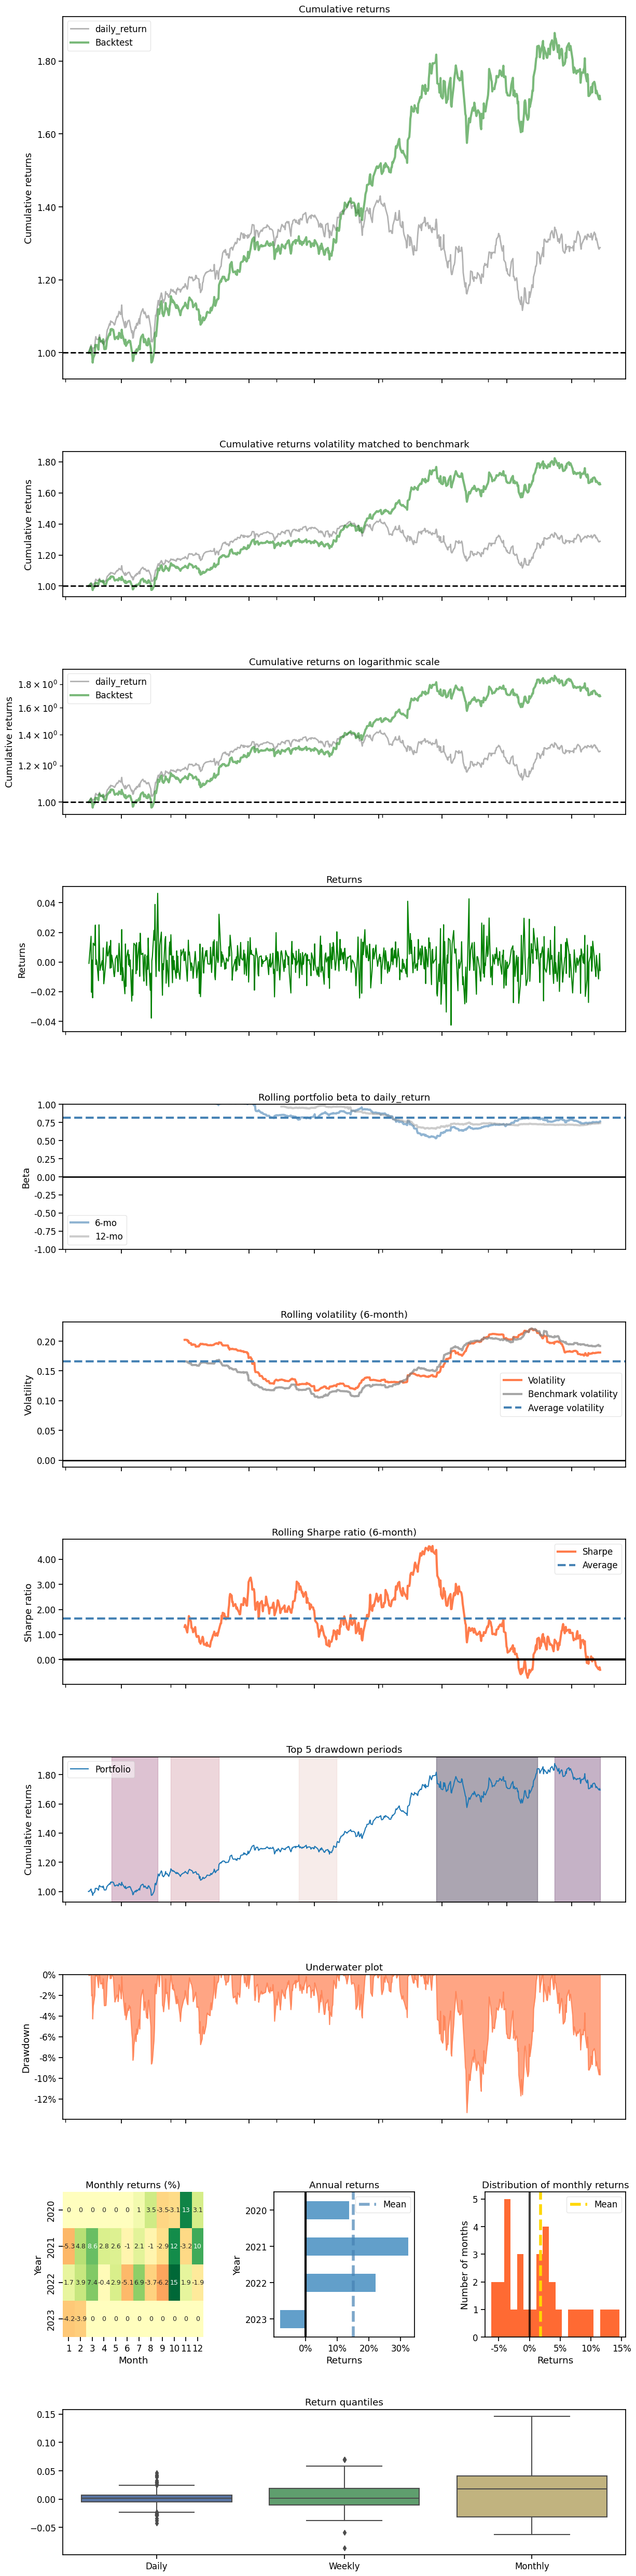

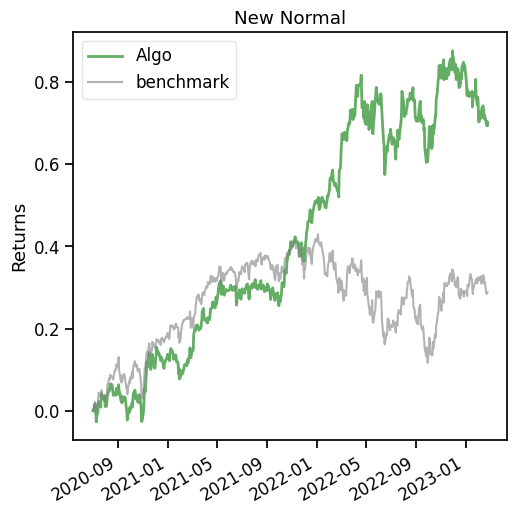

In [50]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI',
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])